This Kernel implements a modified version of **a state-of-art end-to-end neural correference resolution model** published in 2017: https://www.aclweb.org/anthology/D17-1018.
This completition only focus on a specific case of  the generic reference resolution problem, and we only need pick out the correct mention from two candidates, which simplifies the model implementation.

You can compare the result of this model  with the result by other non-RNN based DL models implemented in another kernel: https://www.kaggle.com/keyit92/coreference-resolution-by-mlp-cnn-coattention-nn. 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
print(os.listdir("data"))

# Any results you write to the current directory are saved as output.

['.vector_cache', 'gap', 'gendered-pronoun-resolution', 'ontonotes', 'predictions_end2end_trained1.csv', 'predictions_end2end_trained2.csv', 'right_answers.csv']


In [2]:
DATA_ROOT = 'data'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap')
SUB_DATA_FOLDER = os.path.join(DATA_ROOT, 'gendered-pronoun-resolution')
#FAST_TEXT_DATA_FOLDER = os.path.join(DATA_ROOT, 'fasttext-crawl-300d-2M.vec')

# Import Data

In [3]:
test_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-development.tsv')
train_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-test-neutral-spivak.tsv')
dev_df_path = os.path.join(GAP_DATA_FOLDER, 'gap-validation-neutral-spivak.tsv')

train_df = pd.read_csv(train_df_path, sep='\t')
test_df = pd.read_csv(test_df_path, sep='\t')
dev_df = pd.read_csv(dev_df_path, sep='\t')

# pd.options.display.max_colwidth = 1000

In [4]:
train_df.tail()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
1995,test-1996,"The sole exception was Wimbledon, where ey pla...",Ey,476,Goolagong Cawley,397,True,Peggy Michel,429,False,http://en.wikipedia.org/wiki/Evonne_Goolagong_...
1996,test-1997,"According to news reports, both Moore and Fily...",em,338,Esther Sheryl Wood,263,True,Barbara Morgan,403,False,http://en.wikipedia.org/wiki/Hastings_Arthur_Wise
1997,test-1998,"In June 2009, due to the popularity of the Sab...",Ey,328,Kayla,363,True,Natasha Henstridge,410,False,http://en.wikipedia.org/wiki/Raya_Meddine
1998,test-1999,Ey was delivered to the Norwegian passenger sh...,ey,303,Irma,253,True,Bergen,272,False,http://en.wikipedia.org/wiki/SS_Irma_(1905)
1999,test-2000,"Meg and Vicky each have three siblings, and ha...",eir,275,Vicky Austin,217,True,Polly O'Keefe,260,False,http://en.wikipedia.org/wiki/Vicky_Austin


# Explore Features for Building Mention-Pair Distributed Representation

In [5]:
spacy_model = "en_core_web_lg"

In [6]:
from spacy.lang.en import English
from spacy.pipeline import DependencyParser
import spacy
from nltk import Tree

from keras.preprocessing import sequence
from keras.preprocessing import text as ktext

Using TensorFlow backend.


In [7]:
spacy.__version__

'2.1.3'

In [8]:
nlp = spacy.load(spacy_model)

def bs(list_, target_):
    lo, hi = 0, len(list_) -1
    
    while lo < hi:
        mid = lo + int((hi - lo) / 2)
        
        if target_ < list_[mid]:
            hi = mid
        elif target_ > list_[mid]:
            lo = mid + 1
        else:
            return mid + 1
    return lo

def bs_(list_, target_):
    lo, hi = 0, len(list_) -1
    
    while lo < hi:
        mid = lo + int((hi - lo) / 2)
        
        if target_ < list_[mid]:
            hi = mid
        elif target_ > list_[mid]:
            lo = mid + 1
        else:
            return mid
    return lo

def ohe_dist(dist, buckets):
    idx = bs_(buckets, dist)
    oh = np.zeros(shape=(len(buckets),), dtype=np.float32)
    oh[idx] = 1
    
    return oh

 ##  Position Features

Encode the absolute positions in the sentence and the relative position between the pronoun and the entities.

In [9]:
num_pos_features = 45

In [10]:
def extrac_positional_features(text, char_offset1, char_offset2):
    doc = nlp(text)
    max_len = 64
    
    # char offset to token offset
    lens = [token.idx for token in doc]
    mention_offset1 = bs(lens, char_offset1) - 1
    mention_offset2 = bs(lens, char_offset2) - 1
    
    # token offset to sentence offset
    lens = [len(sent) for sent in doc.sents]
    acc_lens = [len_ for len_ in lens]
    pre_len = 0
    for i in range(0, len(acc_lens)):
        pre_len += acc_lens[i]
        acc_lens[i] = pre_len
    sent_index1 = bs(acc_lens, mention_offset1)
    sent_index2 = bs(acc_lens, mention_offset2)
    
    sent1 = list(doc.sents)[sent_index1]
    sent2 = list(doc.sents)[sent_index2]
    
    # buckets
    bucket_dist = [1, 2, 3, 4, 5, 8, 16, 32, 64]
    
    # relative distance
    dist = mention_offset2 - mention_offset1
    dist_oh = ohe_dist(dist, bucket_dist)
    
    # buckets
    bucket_pos = [0, 1, 2, 3, 4, 5, 8, 16, 32]
    
    # absolute position in the sentence
    sent_pos1 = mention_offset1 + 1
    if sent_index1 > 0:
        sent_pos1 = mention_offset1 - acc_lens[sent_index1-1]
    sent_pos_oh1 = ohe_dist(sent_pos1, bucket_pos)
    sent_pos_inv1 = len(sent1) - sent_pos1
    assert sent_pos_inv1 >= 0
    sent_pos_inv_oh1 = ohe_dist(sent_pos_inv1, bucket_pos)
    
    sent_pos2 = mention_offset2 + 1
    if sent_index2 > 0:
        sent_pos2 = mention_offset2 - acc_lens[sent_index2-1]
    sent_pos_oh2 = ohe_dist(sent_pos2, bucket_pos)
    sent_pos_inv2 = len(sent2) - sent_pos2
    if sent_pos_inv2 < 0:
        print(sent_pos_inv2)
        print(len(sent2))
        print(sent_pos2)
        raise ValueError
    sent_pos_inv_oh2 = ohe_dist(sent_pos_inv2, bucket_pos)
    
    sent_pos_ratio1 = sent_pos1 / len(sent1)
    sent_pos_ratio2 = sent_pos2 / len(sent2)
    
    return dist_oh, sent_pos_oh1, sent_pos_oh2, sent_pos_inv_oh1, sent_pos_inv_oh2

In [11]:
def create_dist_features(df, text_column, pronoun_offset_column, name_offset_column):
    text_offset_list = df[[text_column, pronoun_offset_column, name_offset_column]].values.tolist()
    num_features = num_pos_features
    
    pos_feature_matrix = np.zeros(shape=(len(text_offset_list), num_features))
    for text_offset_index in range(len(text_offset_list)):
        text_offset = text_offset_list[text_offset_index]
        dist_oh, sent_pos_oh1, sent_pos_oh2, sent_pos_inv_oh1, sent_pos_inv_oh2 = extrac_positional_features(text_offset[0], text_offset[1], text_offset[2])
        
        feature_index = 0
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(dist_oh)] = np.asarray(dist_oh)
        feature_index += len(dist_oh)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_oh1)] = np.asarray(sent_pos_oh1)
        feature_index += len(sent_pos_oh1)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_oh2)] = np.asarray(sent_pos_oh2)
        feature_index += len(sent_pos_oh2)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_inv_oh1)] = np.asarray(sent_pos_inv_oh1)
        feature_index += len(sent_pos_inv_oh1)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_inv_oh2)] = np.asarray(sent_pos_inv_oh2)
        feature_index += len(sent_pos_inv_oh2)
    
    return pos_feature_matrix

## Extract Sentences

Select the surrounding 100 words around the mention in the sentence.

In [12]:
max_len = 50 # longer than 99% of the sentences

In [13]:
seq_list = list()
def extract_sents(text, char_offset_p, char_offset_a, char_offset_b, id):
    global max_len
    global seq_list
    
    seq_list.append(list())
    
    doc = nlp(text)
    token_lens = [token.idx for token in doc]
    
    char_offsets = [char_offset_p, char_offset_a, char_offset_b]
    sent_list = list()
    
    for char_offset in char_offsets:
        # char offset to token offset
        mention_offset = bs(token_lens, char_offset) - 1
        # mention_word
        mention = doc[mention_offset]
    
        # token offset to sentence offset
        lens = [len(sent) for sent in doc.sents]
        acc_lens = [len_ for len_ in lens]
        pre_len = 0
        for i in range(0, len(acc_lens)):
            pre_len += acc_lens[i]
            acc_lens[i] = pre_len
        sent_index = bs(acc_lens, mention_offset)
        # mention sentence
        sent = list(doc.sents)[sent_index]
        
        # absolute position in the sentence
        sent_pos = mention_offset + 1
        if sent_index > 0:
            sent_pos = mention_offset - acc_lens[sent_index-1]
        
        # clip the sentence if it is longer than max length
        if len(sent) > max_len:
            # make sure the mention is in the sentence span
            if sent_pos < max_len-1:
                sent_list.append(sent[0:max_len].text)
                sent_list.append(sent_pos)
                seq_list[-1].append(sent[0:max_len])
            else:
                sent_list.append(sent[sent_pos-max_len+2 : min(sent_pos+2, len(sent))].text)
                sent_list.append(max_len-2)
                seq_list[-1].append(sent[sent_pos-max_len+2 : min(sent_pos+2, len(sent))])
        else:
            sent_list.append(sent.text)
            sent_list.append(sent_pos)
            seq_list[-1].append(sent)
        
    return pd.Series([id] + sent_list, index=['ID', 'Pronoun-Sent', 'Pronoun-Sent-Offset', 'A-Sent', 'A-Sent-Offset', 'B-Sent', 'B-Sent-Offset'])

def add_sent_columns(df, text_column, pronoun_offset_column, a_offset_column, b_offset_column):
    global seq_list
    seq_list = list()
    sent_df = df.apply(lambda row: extract_sents(row.loc[text_column], row[pronoun_offset_column], row[a_offset_column], row[b_offset_column], row['ID']), axis=1)
    df = df.join(sent_df.set_index('ID'), on='ID')
    return df, seq_list

## Create Train, Dev and Test Data

In [14]:
seq_list = list()
train_df, train_tokenized = add_sent_columns(train_df, 'Text', 'Pronoun-offset', 'A-offset', 'B-offset')
seq_list = list()
test_df, test_tokenized = add_sent_columns(test_df, 'Text', 'Pronoun-offset', 'A-offset', 'B-offset')
seq_list = list()
dev_df, dev_tokenized = add_sent_columns(dev_df, 'Text', 'Pronoun-offset', 'A-offset', 'B-offset')

# df apply will call the first row twice, remove the first one
train_tokenized = train_tokenized[1:]
test_tokenized = test_tokenized[1:]
dev_tokenized = dev_tokenized[1:]

### Create Vocab and Embedding Matrix

In [15]:
embed_size = 300
max_features = 80000

# generate word index
word_index = dict()
idx = 1
for text_ in train_tokenized+test_tokenized+dev_tokenized:
    for sent_ in text_:
        for word_ in sent_:
            if word_.text not in word_index and nlp.vocab.has_vector(word_.text):
                word_index[word_.text] = idx
                idx += 1

nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))
        
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = None
    if nlp.vocab.has_vector(word):
        embedding_vector = nlp.vocab.vectors[nlp.vocab.strings[word]]
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector
        
print(embedding_matrix.shape)

# generate pos tag index
pos_index = dict()
idx = 1
for text_ in train_tokenized+test_tokenized+dev_tokenized:
    for sent_ in text_:
        for word_ in sent_:
            if word_.pos not in pos_index:
                pos_index[word_.pos] = idx
                idx += 1

def sentences_to_sequences(tokenized_):
    return list(map(
        lambda sent_tokenized: list(map(
            lambda token_: word_index[token_.text] if token_.text in word_index else 0,
            sent_tokenized
        )),
        tokenized_
    ))

def poses_to_sequences(tokenized_):
    return list(map(
        lambda sent_tokenized: list(map(
            lambda token_: pos_index[token_.pos] if token_.pos in pos_index else 0,
            sent_tokenized
        )),
        tokenized_
    ))
    

(22283, 300)


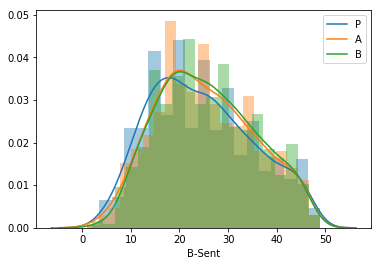

In [17]:
import seaborn as sns

sns.distplot(train_df['Pronoun-Sent'].map(lambda ele: len(ele.split(" "))), kde_kws={"label": "P"})

sns.distplot(train_df['A-Sent'].map(lambda ele: len(ele.split(" "))), kde_kws={"label": "A"})

sns.distplot(train_df['B-Sent'].map(lambda ele: len(ele.split(" "))), kde_kws={"label": "B"})

In [18]:
train_p_tokenized = sentences_to_sequences([row[0] for row in train_tokenized])
train_a_tokenized = sentences_to_sequences([row[1] for row in train_tokenized])
train_b_tokenized = sentences_to_sequences([row[2] for row in train_tokenized])

test_p_tokenized = sentences_to_sequences([row[0] for row in test_tokenized])
test_a_tokenized = sentences_to_sequences([row[1] for row in test_tokenized])
test_b_tokenized = sentences_to_sequences([row[2] for row in test_tokenized])

dev_p_tokenized = sentences_to_sequences([row[0] for row in dev_tokenized])
dev_a_tokenized = sentences_to_sequences([row[1] for row in dev_tokenized])
dev_b_tokenized = sentences_to_sequences([row[2] for row in dev_tokenized])

seq_p_train = sequence.pad_sequences(train_p_tokenized, maxlen = max_len, padding='post')
seq_a_train = sequence.pad_sequences(train_a_tokenized, maxlen = max_len, padding='post')
seq_b_train = sequence.pad_sequences(train_b_tokenized, maxlen = max_len, padding='post')

seq_p_test = sequence.pad_sequences(test_p_tokenized, maxlen = max_len, padding='post')
seq_a_test = sequence.pad_sequences(test_a_tokenized, maxlen = max_len, padding='post')
seq_b_test = sequence.pad_sequences(test_b_tokenized, maxlen = max_len, padding='post')

seq_p_dev = sequence.pad_sequences(dev_p_tokenized, maxlen = max_len, padding='post')
seq_a_dev = sequence.pad_sequences(dev_a_tokenized, maxlen = max_len, padding='post')
seq_b_dev = sequence.pad_sequences(dev_b_tokenized, maxlen = max_len, padding='post')

train_p_pos = poses_to_sequences([row[0] for row in train_tokenized])
train_a_pos = poses_to_sequences([row[1] for row in train_tokenized])
train_b_pos = poses_to_sequences([row[2] for row in train_tokenized])

test_p_pos = poses_to_sequences([row[0] for row in test_tokenized])
test_a_pos = poses_to_sequences([row[1] for row in test_tokenized])
test_b_pos = poses_to_sequences([row[2] for row in test_tokenized])

dev_p_pos = poses_to_sequences([row[0] for row in dev_tokenized])
dev_a_pos = poses_to_sequences([row[1] for row in dev_tokenized])
dev_b_pos = poses_to_sequences([row[2] for row in dev_tokenized])

pos_p_train = sequence.pad_sequences(train_p_pos, maxlen = max_len, padding='post')
pos_a_train = sequence.pad_sequences(train_a_pos, maxlen = max_len, padding='post')
pos_b_train = sequence.pad_sequences(train_b_pos, maxlen = max_len, padding='post')

pos_p_test = sequence.pad_sequences(test_p_pos, maxlen = max_len, padding='post')
pos_a_test = sequence.pad_sequences(test_a_pos, maxlen = max_len, padding='post')
pos_b_test = sequence.pad_sequences(test_b_pos, maxlen = max_len, padding='post')

pos_p_dev = sequence.pad_sequences(dev_p_pos, maxlen = max_len, padding='post')
pos_a_dev = sequence.pad_sequences(dev_a_pos, maxlen = max_len, padding='post')
pos_b_dev = sequence.pad_sequences(dev_b_pos, maxlen = max_len, padding='post')

index_p_train = train_df['Pronoun-Sent-Offset'].values
index_a_train = train_df['A-Sent-Offset'].values
index_b_train = train_df['B-Sent-Offset'].values

index_p_test = test_df['Pronoun-Sent-Offset'].values
index_a_test = test_df['A-Sent-Offset'].values
index_b_test = test_df['B-Sent-Offset'].values

index_p_dev = dev_df['Pronoun-Sent-Offset'].values
index_a_dev = dev_df['A-Sent-Offset'].values
index_b_dev = dev_df['B-Sent-Offset'].values

pa_pos_tra = create_dist_features(train_df, 'Text', 'Pronoun-offset', 'A-offset')
pa_pos_dev = create_dist_features(dev_df, 'Text', 'Pronoun-offset', 'A-offset')
pa_pos_test = create_dist_features(test_df, 'Text', 'Pronoun-offset', 'A-offset')

pb_pos_tra = create_dist_features(train_df, 'Text', 'Pronoun-offset', 'B-offset')
pb_pos_dev = create_dist_features(dev_df, 'Text', 'Pronoun-offset', 'B-offset')
pb_pos_test = create_dist_features(test_df, 'Text', 'Pronoun-offset', 'B-offset')

In [19]:
X_train = [seq_p_train, seq_a_train, seq_b_train, pos_p_train, pos_a_train, pos_b_train, index_p_train, index_a_train, index_b_train, pa_pos_tra, pb_pos_tra]
X_dev = [seq_p_dev, seq_a_dev, seq_b_dev, pos_p_dev, pos_a_dev, pos_b_dev, index_p_dev, index_a_dev, index_b_dev, pa_pos_dev, pb_pos_dev]
X_test = [seq_p_test, seq_a_test, seq_b_test, pos_p_test, pos_a_test, pos_b_test, index_p_test, index_a_test, index_b_test, pa_pos_test, pb_pos_test]

In [20]:
def _row_to_y(row):
    if row.loc['A-coref']:
        return 0
    if row.loc['B-coref']:
        return 1
    return 2

y_tra = train_df.apply(_row_to_y, axis=1)
y_dev = dev_df.apply(_row_to_y, axis=1)
y_test = test_df.apply(_row_to_y, axis=1)

# Define Keras Layers

In [21]:
import numpy as np
from keras import backend
from keras import layers
from keras import models

from keras import initializers, regularizers, constraints, activations
from keras.engine import Layer
import keras.backend as K
from keras.layers import merge

import tensorflow as tf

In [22]:
def _dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
    
class AttentionWeight(Layer):
    """
        This code is a modified version of cbaziotis implementation:  GithubGist cbaziotis/AttentionWithContext.py
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, steps)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWeight())
        """

    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWeight, self).__init__(**kwargs)

    def build(self, input_shape):
        shape1 = input_shape[0]
        shape2 = input_shape[1]

        self.W = self.add_weight((shape2[-1], shape1[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((shape2[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, inputs, mask=None):
        x = inputs[0]
        u = inputs[1]
        
        uit = _dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = K.batch_dot(uit, u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        return a

    def compute_output_shape(self, input_shape):
        if not isinstance(input_shape, list) or len(input_shape) != 2:
            raise ValueError('A `Dot` layer should be called '
                             'on a list of 2 inputs.')
        shape1 = list(input_shape[0])
        shape2 = list(input_shape[1])
        
        return shape1[0], shape1[1]

    def get_config(self):
        config = {
            'W_regularizer': regularizers.serialize(self.W_regularizer),
            'b_regularizer': regularizers.serialize(self.b_regularizer),
            'W_constraint': constraints.serialize(self.W_constraint),
            'b_constraint': constraints.serialize(self.b_constraint),
            'bias': self.bias
        }
        base_config = super(AttentionWeight, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    
class FeatureSelection1D(Layer):
    """
        Normalize feature along a specific axis.
        Supports Masking.

        # Input shape
            A ND tensor with shape: `(samples, timesteps, features)
            A 2D tensor with shape: [samples, num_selected_features]
        # Output shape
            ND tensor with shape: `(samples, num_selected_features, features)`.
        :param kwargs:
        """

    def __init__(self, num_selects, **kwargs):

        self.num_selects = num_selects
        self.supports_masking = True
        super(FeatureSelection1D, self).__init__(**kwargs)

    def build(self, input_shape):

        super(FeatureSelection1D, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # don't pass the mask to the next layers
        return None

    def call(self, inputs, mask=None):
        if not isinstance(inputs, list) or len(inputs) != 2:
            raise ValueError('FeatureSelection1D layer should be called '
                             'on a list of 2 inputs.')

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a = K.cast(mask, K.floatx()) * inputs[0]
        else:
            a = inputs[0]

        b = inputs[1]

        a = tf.batch_gather(
            a, b
        )

        return a

    def compute_output_shape(self, input_shape):
        if not isinstance(input_shape, list) or len(input_shape) != 2:
            raise ValueError('A `FeatureSelection1D` layer should be called '
                             'on a list of 2 inputs.')
        shape1 = list(input_shape[0])
        shape2 = list(input_shape[1])

        if shape2[0] != shape1[0]:
            raise ValueError("batch size must be same")

        if shape2[1] != self.num_selects:
            raise ValueError("must conform to the num_select")

        return (shape1[0], self.num_selects, shape1[2])

    def get_config(self):
        config = {
            'num_selects': self.num_selects
        }
        base_config = super(FeatureSelection1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# Build and Train Model

In [23]:
from keras import callbacks as kc
from keras import optimizers as ko
from keras import initializers, regularizers, constraints
import keras
import matplotlib.pyplot as plt
from IPython.display import SVG

histories = list()
file_paths = list()
cos = list()

## End-to-End RNN Attention Model

### Define Model

In [24]:
def build_e2e_birnn_attention_model(
        voca_dim, time_steps, pos_tag_size, pos_tag_dim, extra_feature_dims,
        output_dim, rnn_dim, model_dim, mlp_dim,
        item_embedding=None, rnn_depth=1, mlp_depth=1,
        drop_out=0.5, rnn_drop_out=0., rnn_state_drop_out=0.,
        trainable_embedding=False, gpu=False, return_customized_layers=False):
    """
    Create A End-to-End Bidirectional RNN Attention Model.

    :param voca_dim: vocabulary dimension size.
    :param time_steps: the length of input
    :param extra_feature_dims: the dimention size of the auxilary feature
    :param output_dim: the output dimension size
    :param model_dim: rrn dimension size
    :param mlp_dim: the dimension size of fully connected layer
    :param item_embedding: integer, numpy 2D array, or None (default=None)
        If item_embedding is a integer, connect a randomly initialized embedding matrix to the input tensor.
        If item_embedding is a matrix, this matrix will be used as the embedding matrix.
        If item_embedding is None, then connect input tensor to RNN layer directly.
    :param rnn_depth: rnn depth
    :param mlp_depth: the depth of fully connected layers
    :param drop_out: dropout rate of fully connected layers
    :param rnn_drop_out: dropout rate of rnn layers
    :param rnn_state_drop_out: dropout rate of rnn state tensor
    :param trainable_embedding: boolean
    :param gpu: boolean, default=False
        If True, CuDNNLSTM is used instead of LSTM for RNN layer.
    :param return_customized_layers: boolean, default=False
        If True, return model and customized object dictionary, otherwise return model only
    :return: keras model
    """
    
    # sequences inputs
    if item_embedding is not None:
        inputp = models.Input(shape=(time_steps,), dtype='int32', name='inputp')
        inputa = models.Input(shape=(time_steps,), dtype='int32', name='inputa')
        inputb = models.Input(shape=(time_steps,), dtype='int32', name='inputb')
        inputs = [inputp, inputa, inputb]
        
        if isinstance(item_embedding, np.ndarray):
            assert voca_dim == item_embedding.shape[0]
            embed_dim = item_embedding.shape[1]
            emb_layer = layers.Embedding(
                voca_dim, item_embedding.shape[1], input_length=time_steps,
                weights=[item_embedding, ], trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )
        elif utils.is_integer(item_embedding):
            embed_dim = item_embedding
            emb_layer = layers.Embedding(
                voca_dim, item_embedding, input_length=time_steps,
                trainable=trainable_embedding,
                mask_zero=False, name='embedding_layer0'
            )
        else:
            raise ValueError("item_embedding must be either integer or numpy matrix")

        xs = list(map(
            lambda input_: emb_layer(input_),
            inputs
        ))
    else:
        inputp = models.Input(shape=(time_steps, voca_dim), dtype='float32', name='inputp')
        inputa = models.Input(shape=(time_steps, voca_dim), dtype='float32', name='inputa')
        inputb = models.Input(shape=(time_steps, voca_dim), dtype='float32', name='inputb')
        embed_dim = voca_dim
        xs = [inputp, inputa, inputb]
        
    # pos tag
    inputposp = models.Input(shape=(time_steps,), dtype='int32', name='inputposp')
    inputposa = models.Input(shape=(time_steps,), dtype='int32', name='inputposa')
    inputposb = models.Input(shape=(time_steps,), dtype='int32', name='inputposb')
    inputpos = [inputposp, inputposa, inputposb]
    pos_emb_layer = layers.Embedding(
        pos_tag_size, pos_tag_dim, input_length=time_steps,
        trainable=True, mask_zero=False, name='pos_embedding_layer0'
    )
    xpos = list(map(
        lambda input_: pos_emb_layer(input_),
        inputpos
    ))
    
    embed_concate_layer = layers.Concatenate(axis=2, name="embed_concate_layer")
    for i in range(len(xs)):
        xs[i] = embed_concate_layer([xs[i], xpos[i]])
    
    # mention position in the sentence
    inputpi = models.Input(shape=(1,), dtype='int32', name='inputpi')
    inputai = models.Input(shape=(1,), dtype='int32', name='inputai')
    inputbi = models.Input(shape=(1,), dtype='int32', name='inputbi')
    xis = [inputpi, inputai, inputbi]
    
    # addtional mention-pair features
    inputpa = models.Input(shape=(extra_feature_dims,), dtype='float32', name='inputpa')
    inputpb = models.Input(shape=(extra_feature_dims,), dtype='float32', name='inputpb')
    xextrs = [inputpa, inputpb]
    
    # rnn
    birnns = list()
    rnn_batchnorms = list()
    rnn_dropouts = list()
    if gpu:
        # rnn encoding
        for i in range(rnn_depth):
            rnn_dropout = layers.SpatialDropout1D(rnn_drop_out)
            birnn = layers.Bidirectional(
                layers.CuDNNGRU(rnn_dim, return_sequences=True),
                name='bi_lstm_layer' + str(i))
            rnn_batchnorm = layers.BatchNormalization(name='rnn_batch_norm_layer' + str(i))
            
            birnns.append(birnn)
            rnn_dropouts.append(rnn_dropout)
            rnn_batchnorms.append(rnn_batchnorm)
        
        xs_ = list()
        for x_ in xs:
            for i in range(len(birnns)):
                x_ = rnn_dropouts[i](x_)
                x_ = birnns[i](x_)
                x_ = rnn_batchnorms[i](x_)
            xs_.append(x_)
        xs = xs_
    else:
        # rnn encoding
        for i in range(rnn_depth):
            birnn = layers.Bidirectional(
                layers.GRU(rnn_dim, return_sequences=True, dropout=rnn_drop_out,
                            recurrent_dropout=rnn_state_drop_out),
                name='bi_lstm_layer' + str(i))
            rnn_batchnorm = layers.BatchNormalization(name='rnn_batch_norm_layer' + str(i))
            
            birnns.append(birnn)
            rnn_batchnorms.append(rnn_batchnorm)
            
        xs_ = list()
        for x_ in xs:
            for i in range(len(birnns)):
                x_ = birnns[i](x_)
                x_ = rnn_batchnorms[i](x_)
            xs_.append(x_)
        xs = xs_
    
    # attention aggregated rnn embedding + mention rnn embedding + mention-pair features
    select_layer = FeatureSelection1D(1, name='boundary_selection_layer')
    flatten_layer1 = layers.Flatten('channels_first', name="flatten_layer1")
    permute_layer = layers.Permute((2, 1), name='permuted_attention_x')
    attent_weight = AttentionWeight(name="attention_weight")
    focus_layer = layers.Dot([2, 1], name='focus' + '_layer')
    reshape_layer = layers.Reshape((1, rnn_dim*2), name="reshape_layer")
    concate_layer = layers.Concatenate(axis=1, name="attention_concate_layer")
    atten_dropout_layer = layers.Dropout(drop_out, name='attention_dropout_layer')
    map_layer1 = layers.Dense(model_dim, activation="relu", name="map_layer1")
    #map_layer2 = layers.TimeDistributed(layers.Dense(model_dim, activation="relu"), name="map_layer2")
    map_layer2 = map_layer1
    flatten_layer = layers.Flatten('channels_first', name="flatten_layer")
    for i in range(len(xs)):
        if i == 0:
            map_layer = map_layer1
        else:
            map_layer = map_layer2
            
        select_ = select_layer([xs[i], xis[i]])
        flatten_select_ = flatten_layer1(select_)
        att = attent_weight([xs[i], flatten_select_])
        
        focus = focus_layer([permute_layer(xs[i]), att])
        xs[i] = concate_layer([select_, reshape_layer(focus)])
        xs[i] = flatten_layer(xs[i])
        xs[i] = atten_dropout_layer(xs[i])
        xs[i] = map_layer(xs[i])
    
    feature_dropout_layer = layers.Dropout(rate=drop_out, name="feature_dropout_layer")
    feature_map_layer = layers.Dense(model_dim, activation="relu",name="feature_map_layer")
    xextrs = [feature_map_layer(feature_dropout_layer(xextr)) for xextr in xextrs]
    
    x = layers.Concatenate(axis=1, name="concat_feature_layer")(xs + xextrs)
    x = layers.Dropout(drop_out, name='dropout_layer')(x)

    # MLP Layers
    for i in range(mlp_depth - 1):
        x = layers.Dense(mlp_dim, activation='selu', kernel_initializer='lecun_normal', name='selu_layer' + str(i))(x)
        x = layers.AlphaDropout(drop_out, name='alpha_layer' + str(i))(x)

    outputs = layers.Dense(output_dim, activation="softmax", name="softmax_layer0")(x)

    model = models.Model([inputp, inputa, inputb] + inputpos + xis + [inputpa, inputpb], outputs)

    if return_customized_layers:
        return model, {'FeatureSelection1D': FeatureSelection1D, 'AttentionWeight': AttentionWeight}

    return model

### Build Model

In [25]:
voca_dim = embedding_matrix.shape[0]
pos_tag_size = len(pos_index) + 1 # my edit
time_steps = max_len

embed_dim = embedding_matrix.shape[1]
pos_tag_dim = 5
extra_feature_dims = num_pos_features
output_dim = 3
rnn_dim = 50
model_dim = 10
mlp_dim = 10
rnn_depth = 1
mlp_depth=1
drop_out=0.2
rnn_drop_out=0.5
gpu = False
return_customized_layers=True

model, co = build_e2e_birnn_attention_model(
        voca_dim, time_steps, pos_tag_size, pos_tag_dim, extra_feature_dims, output_dim, rnn_dim, model_dim, mlp_dim,
        item_embedding=embedding_matrix, rnn_depth=rnn_depth, mlp_depth=mlp_depth,
        drop_out=drop_out, rnn_drop_out=rnn_drop_out, rnn_state_drop_out=rnn_drop_out,
        trainable_embedding=False, gpu=gpu, return_customized_layers=return_customized_layers)
cos.append(co)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
import pydot

In [27]:

from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [28]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputp (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
inputposp (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
inputa (InputLayer)             (None, 50)           0                                            
__________________________________________________________________________________________________
inputposa (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
inputb (In

                                                                 reshape_layer[2][0]              
__________________________________________________________________________________________________
flatten_layer (Flatten)         (None, 200)          0           attention_concate_layer[0][0]    
                                                                 attention_concate_layer[1][0]    
                                                                 attention_concate_layer[2][0]    
__________________________________________________________________________________________________
inputpa (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
inputpb (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
attention_

### Train Model

In [29]:
import tensorflow
tensorflow.__version__

'1.13.1'

In [30]:
adam = ko.Nadam(clipnorm=1.0)
model.compile(adam, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

file_path = "best_e2e_rnn_atten_model.hdf5"
check_point = kc.ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1, save_best_only = True, mode = "min")
early_stop = kc.EarlyStopping(monitor = "val_loss", mode = "min", patience=5)
history = model.fit(X_train, y_tra, batch_size=30, epochs=40, validation_data=(X_dev, y_dev),
                    callbacks = [check_point, early_stop])

file_paths.append(file_path)
histories.append(np.min(np.asarray(history.history['val_loss'])))

del model, history
gc.collect()

Instructions for updating:
Use tf.cast instead.


C:\Users\Isak\.conda\envs\gender\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Isak\.conda\envs\gender\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Isak\.conda\envs\gender\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2000 samples, validate on 454 samples
Epoch 1/40
2000/2000 [==============================] - ETA: 9:38 - loss: 0.8733 - sparse_categorical_accuracy: 0.633 - ETA: 4:51 - loss: 1.3047 - sparse_categorical_accuracy: 0.500 - ETA: 3:15 - loss: 1.2715 - sparse_categorical_accuracy: 0.511 - ETA: 2:26 - loss: 1.3232 - sparse_categorical_accuracy: 0.483 - ETA: 1:57 - loss: 1.2861 - sparse_categorical_accuracy: 0.480 - ETA: 1:38 - loss: 1.2351 - sparse_categorical_accuracy: 0.494 - ETA: 1:24 - loss: 1.2707 - sparse_categorical_accuracy: 0.485 - ETA: 1:14 - loss: 1.2728 - sparse_categorical_accuracy: 0.487 - ETA: 1:06 - loss: 1.2355 - sparse_categorical_accuracy: 0.500 - ETA: 59s - loss: 1.2576 - sparse_categorical_accuracy: 0.483 - ETA: 54s - loss: 1.2755 - sparse_categorical_accuracy: 0.47 - ETA: 50s - loss: 1.2769 - sparse_categorical_accuracy: 0.46 - ETA: 46s - loss: 1.2715 - sparse_categorical_accuracy: 0.46 - ETA: 42s - loss: 1.2604 - sparse_categorical_accuracy: 0.46 - ETA: 39s -

2000/2000 [==============================] - ETA: 14s - loss: 0.9910 - sparse_categorical_accuracy: 0.66 - ETA: 14s - loss: 1.0022 - sparse_categorical_accuracy: 0.66 - ETA: 13s - loss: 1.0177 - sparse_categorical_accuracy: 0.61 - ETA: 13s - loss: 0.9544 - sparse_categorical_accuracy: 0.61 - ETA: 13s - loss: 1.0182 - sparse_categorical_accuracy: 0.57 - ETA: 12s - loss: 0.9997 - sparse_categorical_accuracy: 0.58 - ETA: 12s - loss: 0.9937 - sparse_categorical_accuracy: 0.59 - ETA: 12s - loss: 0.9724 - sparse_categorical_accuracy: 0.60 - ETA: 12s - loss: 0.9583 - sparse_categorical_accuracy: 0.60 - ETA: 12s - loss: 0.9643 - sparse_categorical_accuracy: 0.59 - ETA: 11s - loss: 0.9407 - sparse_categorical_accuracy: 0.60 - ETA: 11s - loss: 0.9543 - sparse_categorical_accuracy: 0.58 - ETA: 11s - loss: 0.9525 - sparse_categorical_accuracy: 0.58 - ETA: 11s - loss: 0.9610 - sparse_categorical_accuracy: 0.57 - ETA: 11s - loss: 0.9591 - sparse_categorical_accuracy: 0.57 - ETA: 10s - loss: 0.9509 -

2000/2000 [==============================] - ETA: 15s - loss: 0.6936 - sparse_categorical_accuracy: 0.80 - ETA: 16s - loss: 0.8063 - sparse_categorical_accuracy: 0.70 - ETA: 15s - loss: 0.8372 - sparse_categorical_accuracy: 0.64 - ETA: 15s - loss: 0.8424 - sparse_categorical_accuracy: 0.62 - ETA: 15s - loss: 0.8649 - sparse_categorical_accuracy: 0.60 - ETA: 14s - loss: 0.8473 - sparse_categorical_accuracy: 0.62 - ETA: 14s - loss: 0.8286 - sparse_categorical_accuracy: 0.62 - ETA: 14s - loss: 0.8025 - sparse_categorical_accuracy: 0.63 - ETA: 14s - loss: 0.7713 - sparse_categorical_accuracy: 0.64 - ETA: 14s - loss: 0.7749 - sparse_categorical_accuracy: 0.64 - ETA: 13s - loss: 0.7697 - sparse_categorical_accuracy: 0.65 - ETA: 13s - loss: 0.7702 - sparse_categorical_accuracy: 0.65 - ETA: 13s - loss: 0.7757 - sparse_categorical_accuracy: 0.64 - ETA: 12s - loss: 0.7666 - sparse_categorical_accuracy: 0.65 - ETA: 12s - loss: 0.7532 - sparse_categorical_accuracy: 0.65 - ETA: 12s - loss: 0.7481 -

2000/2000 [==============================] - ETA: 12s - loss: 0.6458 - sparse_categorical_accuracy: 0.70 - ETA: 12s - loss: 0.6824 - sparse_categorical_accuracy: 0.70 - ETA: 12s - loss: 0.7338 - sparse_categorical_accuracy: 0.68 - ETA: 11s - loss: 0.7048 - sparse_categorical_accuracy: 0.69 - ETA: 11s - loss: 0.7331 - sparse_categorical_accuracy: 0.68 - ETA: 11s - loss: 0.7363 - sparse_categorical_accuracy: 0.68 - ETA: 11s - loss: 0.7528 - sparse_categorical_accuracy: 0.66 - ETA: 11s - loss: 0.7382 - sparse_categorical_accuracy: 0.67 - ETA: 11s - loss: 0.7320 - sparse_categorical_accuracy: 0.67 - ETA: 11s - loss: 0.7412 - sparse_categorical_accuracy: 0.67 - ETA: 11s - loss: 0.7482 - sparse_categorical_accuracy: 0.66 - ETA: 11s - loss: 0.7536 - sparse_categorical_accuracy: 0.66 - ETA: 10s - loss: 0.7575 - sparse_categorical_accuracy: 0.66 - ETA: 10s - loss: 0.7545 - sparse_categorical_accuracy: 0.66 - ETA: 10s - loss: 0.7526 - sparse_categorical_accuracy: 0.66 - ETA: 10s - loss: 0.7438 -

2000/2000 [==============================] - ETA: 13s - loss: 0.7161 - sparse_categorical_accuracy: 0.66 - ETA: 12s - loss: 0.6653 - sparse_categorical_accuracy: 0.70 - ETA: 12s - loss: 0.7833 - sparse_categorical_accuracy: 0.64 - ETA: 12s - loss: 0.7322 - sparse_categorical_accuracy: 0.66 - ETA: 12s - loss: 0.7483 - sparse_categorical_accuracy: 0.64 - ETA: 11s - loss: 0.7366 - sparse_categorical_accuracy: 0.66 - ETA: 11s - loss: 0.7517 - sparse_categorical_accuracy: 0.66 - ETA: 11s - loss: 0.7511 - sparse_categorical_accuracy: 0.66 - ETA: 11s - loss: 0.7566 - sparse_categorical_accuracy: 0.65 - ETA: 11s - loss: 0.7462 - sparse_categorical_accuracy: 0.66 - ETA: 11s - loss: 0.7371 - sparse_categorical_accuracy: 0.67 - ETA: 11s - loss: 0.7176 - sparse_categorical_accuracy: 0.68 - ETA: 11s - loss: 0.7278 - sparse_categorical_accuracy: 0.68 - ETA: 10s - loss: 0.7411 - sparse_categorical_accuracy: 0.67 - ETA: 10s - loss: 0.7420 - sparse_categorical_accuracy: 0.67 - ETA: 10s - loss: 0.7479 -

2000/2000 [==============================] - ETA: 13s - loss: 0.8337 - sparse_categorical_accuracy: 0.56 - ETA: 14s - loss: 0.8299 - sparse_categorical_accuracy: 0.53 - ETA: 14s - loss: 0.7446 - sparse_categorical_accuracy: 0.58 - ETA: 13s - loss: 0.7248 - sparse_categorical_accuracy: 0.63 - ETA: 13s - loss: 0.7838 - sparse_categorical_accuracy: 0.61 - ETA: 13s - loss: 0.7587 - sparse_categorical_accuracy: 0.63 - ETA: 13s - loss: 0.7477 - sparse_categorical_accuracy: 0.63 - ETA: 12s - loss: 0.7764 - sparse_categorical_accuracy: 0.64 - ETA: 12s - loss: 0.7542 - sparse_categorical_accuracy: 0.65 - ETA: 12s - loss: 0.7486 - sparse_categorical_accuracy: 0.65 - ETA: 12s - loss: 0.7365 - sparse_categorical_accuracy: 0.65 - ETA: 11s - loss: 0.7217 - sparse_categorical_accuracy: 0.65 - ETA: 11s - loss: 0.7057 - sparse_categorical_accuracy: 0.66 - ETA: 11s - loss: 0.7175 - sparse_categorical_accuracy: 0.65 - ETA: 10s - loss: 0.7292 - sparse_categorical_accuracy: 0.65 - ETA: 10s - loss: 0.7221 -

2000/2000 [==============================] - ETA: 13s - loss: 0.6055 - sparse_categorical_accuracy: 0.76 - ETA: 13s - loss: 0.6405 - sparse_categorical_accuracy: 0.70 - ETA: 13s - loss: 0.6258 - sparse_categorical_accuracy: 0.73 - ETA: 13s - loss: 0.6227 - sparse_categorical_accuracy: 0.75 - ETA: 13s - loss: 0.6331 - sparse_categorical_accuracy: 0.72 - ETA: 13s - loss: 0.6196 - sparse_categorical_accuracy: 0.72 - ETA: 12s - loss: 0.6189 - sparse_categorical_accuracy: 0.72 - ETA: 12s - loss: 0.6166 - sparse_categorical_accuracy: 0.72 - ETA: 12s - loss: 0.6461 - sparse_categorical_accuracy: 0.71 - ETA: 12s - loss: 0.6586 - sparse_categorical_accuracy: 0.72 - ETA: 12s - loss: 0.6495 - sparse_categorical_accuracy: 0.72 - ETA: 11s - loss: 0.6930 - sparse_categorical_accuracy: 0.69 - ETA: 11s - loss: 0.6909 - sparse_categorical_accuracy: 0.69 - ETA: 11s - loss: 0.6854 - sparse_categorical_accuracy: 0.70 - ETA: 11s - loss: 0.6897 - sparse_categorical_accuracy: 0.69 - ETA: 10s - loss: 0.6988 -

2000/2000 [==============================] - ETA: 12s - loss: 0.6628 - sparse_categorical_accuracy: 0.76 - ETA: 11s - loss: 0.5413 - sparse_categorical_accuracy: 0.80 - ETA: 12s - loss: 0.5719 - sparse_categorical_accuracy: 0.77 - ETA: 12s - loss: 0.5795 - sparse_categorical_accuracy: 0.75 - ETA: 11s - loss: 0.6818 - sparse_categorical_accuracy: 0.72 - ETA: 11s - loss: 0.6727 - sparse_categorical_accuracy: 0.70 - ETA: 11s - loss: 0.6854 - sparse_categorical_accuracy: 0.70 - ETA: 11s - loss: 0.6686 - sparse_categorical_accuracy: 0.70 - ETA: 11s - loss: 0.7018 - sparse_categorical_accuracy: 0.70 - ETA: 11s - loss: 0.6751 - sparse_categorical_accuracy: 0.72 - ETA: 11s - loss: 0.6698 - sparse_categorical_accuracy: 0.71 - ETA: 11s - loss: 0.6689 - sparse_categorical_accuracy: 0.71 - ETA: 10s - loss: 0.6845 - sparse_categorical_accuracy: 0.71 - ETA: 10s - loss: 0.6895 - sparse_categorical_accuracy: 0.70 - ETA: 10s - loss: 0.6752 - sparse_categorical_accuracy: 0.71 - ETA: 10s - loss: 0.6690 -

2000/2000 [==============================] - ETA: 13s - loss: 0.7659 - sparse_categorical_accuracy: 0.60 - ETA: 14s - loss: 0.7372 - sparse_categorical_accuracy: 0.70 - ETA: 13s - loss: 0.6795 - sparse_categorical_accuracy: 0.73 - ETA: 13s - loss: 0.6841 - sparse_categorical_accuracy: 0.71 - ETA: 13s - loss: 0.6974 - sparse_categorical_accuracy: 0.71 - ETA: 13s - loss: 0.7179 - sparse_categorical_accuracy: 0.70 - ETA: 13s - loss: 0.6780 - sparse_categorical_accuracy: 0.72 - ETA: 12s - loss: 0.6630 - sparse_categorical_accuracy: 0.73 - ETA: 12s - loss: 0.6547 - sparse_categorical_accuracy: 0.73 - ETA: 12s - loss: 0.6505 - sparse_categorical_accuracy: 0.73 - ETA: 12s - loss: 0.6703 - sparse_categorical_accuracy: 0.72 - ETA: 11s - loss: 0.6731 - sparse_categorical_accuracy: 0.72 - ETA: 11s - loss: 0.6647 - sparse_categorical_accuracy: 0.73 - ETA: 11s - loss: 0.6694 - sparse_categorical_accuracy: 0.73 - ETA: 11s - loss: 0.6617 - sparse_categorical_accuracy: 0.73 - ETA: 10s - loss: 0.6608 -

2000/2000 [==============================] - ETA: 14s - loss: 0.4191 - sparse_categorical_accuracy: 0.80 - ETA: 14s - loss: 0.5249 - sparse_categorical_accuracy: 0.80 - ETA: 13s - loss: 0.5470 - sparse_categorical_accuracy: 0.77 - ETA: 12s - loss: 0.5989 - sparse_categorical_accuracy: 0.75 - ETA: 12s - loss: 0.5939 - sparse_categorical_accuracy: 0.76 - ETA: 12s - loss: 0.6136 - sparse_categorical_accuracy: 0.74 - ETA: 11s - loss: 0.6449 - sparse_categorical_accuracy: 0.73 - ETA: 11s - loss: 0.6179 - sparse_categorical_accuracy: 0.74 - ETA: 11s - loss: 0.6061 - sparse_categorical_accuracy: 0.74 - ETA: 11s - loss: 0.6105 - sparse_categorical_accuracy: 0.74 - ETA: 11s - loss: 0.6056 - sparse_categorical_accuracy: 0.75 - ETA: 10s - loss: 0.5996 - sparse_categorical_accuracy: 0.75 - ETA: 10s - loss: 0.5951 - sparse_categorical_accuracy: 0.75 - ETA: 10s - loss: 0.5956 - sparse_categorical_accuracy: 0.75 - ETA: 10s - loss: 0.5888 - sparse_categorical_accuracy: 0.75 - ETA: 10s - loss: 0.5888 -

2000/2000 [==============================] - ETA: 12s - loss: 0.6776 - sparse_categorical_accuracy: 0.66 - ETA: 13s - loss: 0.6283 - sparse_categorical_accuracy: 0.66 - ETA: 12s - loss: 0.5870 - sparse_categorical_accuracy: 0.70 - ETA: 12s - loss: 0.6355 - sparse_categorical_accuracy: 0.69 - ETA: 12s - loss: 0.6288 - sparse_categorical_accuracy: 0.68 - ETA: 12s - loss: 0.6653 - sparse_categorical_accuracy: 0.66 - ETA: 11s - loss: 0.6492 - sparse_categorical_accuracy: 0.68 - ETA: 11s - loss: 0.6198 - sparse_categorical_accuracy: 0.70 - ETA: 11s - loss: 0.6397 - sparse_categorical_accuracy: 0.69 - ETA: 11s - loss: 0.6126 - sparse_categorical_accuracy: 0.70 - ETA: 11s - loss: 0.6253 - sparse_categorical_accuracy: 0.70 - ETA: 11s - loss: 0.6093 - sparse_categorical_accuracy: 0.70 - ETA: 10s - loss: 0.6051 - sparse_categorical_accuracy: 0.71 - ETA: 10s - loss: 0.6091 - sparse_categorical_accuracy: 0.71 - ETA: 10s - loss: 0.5972 - sparse_categorical_accuracy: 0.72 - ETA: 10s - loss: 0.5950 -

50

###  Make Prediction

In [31]:
print("load best model: " + str(file_paths[np.argmin(histories)]))
model = models.load_model(
    file_paths[np.argmin(histories)], cos[np.argmin(histories)])

load best model: best_e2e_rnn_atten_model.hdf5


C:\Users\Isak\.conda\envs\gender\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Isak\.conda\envs\gender\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Isak\.conda\envs\gender\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [34]:
print(file_paths)

['best_e2e_rnn_atten_model.hdf5']


In [36]:
y_preds = model.predict(X_test, batch_size = 1024, verbose = 1)

sub_df_path = os.path.join(SUB_DATA_FOLDER, 'sample_submission_stage_1.csv')
sub_df = pd.read_csv(sub_df_path)
sub_df.loc[:, 'A'] = pd.Series(y_preds[:, 0])
sub_df.loc[:, 'B'] = pd.Series(y_preds[:, 1])
sub_df.loc[:, 'NEITHER'] = pd.Series(y_preds[:, 2])

sub_df.head()

2000/2000 [==============================] - ETA:  - 5s 2ms/step


,ID,A,B,NEITHER
0,development-1,0.117889,0.723842,0.158269
1,development-2,0.902018,0.070844,0.027137
2,development-3,0.226897,0.611420,0.161683
3,development-4,0.156174,0.714564,0.129262
4,development-5,0.251448,0.370151,0.378401


In [37]:
sub_df.to_csv("submission.csv", index=False)

## Evaluate model

In [73]:
binary = np.zeros((2000,3),dtype=int)
for i, row in sub_df.iterrows():
    max_ = max(row['A'], row['B'], row['NEITHER'])
    if max_ == row['A']:
        binary[i,0] = 1
    elif max_ == row['B']:
        binary[i,1] = 1
    else:
        binary[i,2] = 1

In [250]:
predictions = pd.DataFrame(binary, columns=['A','B','NEITHER'])
predictions.to_csv('data/predictions_end2end_trained1.csv')

In [271]:
# Load the necessary dataframes
predictions = pd.read_csv('data/predictions_end2end_trained1.csv', index_col=0)
right_answers = pd.read_csv('data/right_answers.csv')
full_data_path = 'data/gendered-pronoun-resolution/test_stage_1.tsv'
#full_data = pd.read_csv(full_data_path, sep = '\t', index_col = 0)
full_data = pd.read_csv(full_data_path, sep = '\t')

### Create bootstrap confidence interval

In [286]:
def bootstrap(gold_df, pred_df, all_data_df, B=10000):
    repeats = 1000
    f1_statistics = []
    bias_statistics = []
    sample_size = len(gold_df)
    indeces = list(range(sample_size))
    
    for idx in range(repeats):
        rows = choices(indeces, k=B)
        boot_gold_df = gold_df[gold_df.index.isin(rows)]
        boot_gold_df.__delitem__("ID")
        boot_pred_df = pred_df[pred_df.index.isin(rows)]
        boot_data_df = all_data_df[all_data_df.index.isin(rows)]
        
        f1 = calculate_f1(boot_gold_df, boot_pred_df)
        #boot_pred_df = pd.DataFrame(binary, columns=['A','B','NEITHER'], index = list(df.index))
        bias = calculate_bias(boot_gold_df, boot_pred_df, boot_data_df)        
        f1_statistics.append(f1)
        bias_statistics.append(bias)
    
    return [f1_statistics, bias_statistics]

In [281]:
def confidence_interval(statistics, confidence_level = 0.95):
    bounds = 50 * (1 - confidence_level)
    lower = np.percentile(statistics, bounds)
    median = np.percentile(statistics, 50)
    upper = np.percentile(statistics, 100 - bounds)
    
    return lower, median, upper

In [282]:
def print_ci(f1, bias, confidence_level = 0.95):
    lower, median,upper = confidence_interval(f1, confidence_level)
    print("%.3f, %s%% Bootstrap CI for F1: [%.3f, %.3f]" % (median, confidence_level*100, lower, upper))
    lower, median,upper = confidence_interval(bias, confidence_level)
    print("%.3f, %s%% Bootstrap CI for bias: [%.3f, %.3f]" % (median, confidence_level*100, lower, upper))

In [283]:
from sklearn.metrics import f1_score

def calculate_f1(gold_df, pred_df):
    gold = gold_df.values[:,1:].astype(int)
    predictions = pred_df.values[:,1:].astype(int)
    
    f1 = f1_score(gold, predictions, average=None)
    
    return f1

In [284]:
def calculate_bias(gold, pred, data_df):
    # Define male and female pronouns
    male_pn = ['He', 'His', 'he', 'him', 'his']
    female_pn = ['Her', 'She', 'her', 'she']
    
    # Find list of indices
    m_idx = []
    fm_idx = []
    #for i in range(data_df.shape[0]):
    for i in list(data_df.index):
        pn = data_df['Pronoun'][i]
        if pn in male_pn:
            #m_idx.append(list(data_df.index)[i])
            m_idx.append(i)
        else:
            #m_idx.append(list(data_df.index)[i])
            fm_idx.append(i)
            
    # Male pred
    male_pred = pred.loc[m_idx, :]
    male_pred = male_pred.values[:, :].astype(int)
    male_gold = gold.loc[m_idx, :]
    male_gold = male_gold.values[:, :].astype(int)

    # Female pred
    female_pred = pred.loc[fm_idx, :]
    female_pred = female_pred.values[:, :].astype(int)
    female_gold = gold.loc[fm_idx, :]
    female_gold = female_gold.values[:, :].astype(int)

    # Calculate scores
    f1_m = f1_score(male_gold, male_pred, average = None)
    f1_fm = f1_score(female_gold, female_pred, average = None)
    
    return f1_fm / f1_m

In [287]:
[f1, bias] = bootstrap(right_answers, predictions, full_data)
print_ci(f1, bias)

0.553, 95.0% Bootstrap CI for F1: [0.405, 0.692]
0.955, 95.0% Bootstrap CI for bias: [0.927, 1.165]
